### Prediction with trained model

1. Loads a model
2. Load weights from a checkpoint
3. Load zarr dataset for prediction (patch generation is handled by this class)
4. Perform prediction
5. Perform checks on subtiles
5. Write results to csv

In [1]:
import torch
def gpu_mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(f'{t/(1024**3):0.2f} Gb Total memory')
    print(f'{c/(1024**3):0.2f} Gb cached memory')
    print(f'{a/(1024**3):0.2f} Gb allocated memory')
    return

In [2]:
import sys
from pathlib import Path

#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch
from torch.utils.data import DataLoader
from utils.data import Pred_Ai224_RG_Zarr,Pred_Sampler_Zarr
from models.unet import Ai224_RG_UNet
from utils.analysis import pred_to_xy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)
tonumpy = lambda x: x.cpu().detach().numpy()

model = Ai224_RG_UNet()
ckpt_file = '../../../dat/Ai224_RG_models/CE_wt244_Adam_run_v3_norm/44587_ckpt.pt'
checkpoint = torch.load(ckpt_file,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint['loss']

model.to(device)
print(f'Validation loss was {loss:0.8f}')

Validation loss was 1.10335231


In [3]:
gpu_mem_stats()

10.92 Gb Total memory
0.01 Gb cached memory
0.01 Gb allocated memory


In [4]:
patch_size=260
output_size = 172
scale = 255.
n_x_patch_per_subtile = 10
n_y_patch_per_subtile = 10
batch_size = n_x_patch_per_subtile*n_y_patch_per_subtile

im_path = '/home/rohan/Remote-AI-root/allen/programs/celltypes/workgroups/mct-t200/Molecular_Genetics_Daigle_Team/Elyse/Unet_WB_testing/547656/'
fname = '0539050069-0070.zarr'

pred_dataset = Pred_Ai224_RG_Zarr(patch_size = patch_size,
                             output_size = output_size,
                             im_path=im_path,
                             fname=fname,
                             scale=scale)

pred_sampler = Pred_Sampler_Zarr(dataset=pred_dataset, 
                                 n_x_patch_per_subtile=n_x_patch_per_subtile, 
                                 n_y_patch_per_subtile=n_y_patch_per_subtile)

pred_dataloader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False,
                            sampler=pred_sampler, drop_last=False, pin_memory=True)

pred_datagen = iter(pred_dataloader)

In [5]:
#Empty subtile for labels:
n_labels = 3
n_channels = 2
x_size = pred_dataset.output_size*pred_sampler.n_x_patch_per_subtile
y_size = pred_dataset.output_size*pred_sampler.n_y_patch_per_subtile
output_size = pred_dataset.output_size
offset = int((pred_dataset.patch_size - pred_dataset.output_size)/2)

In [6]:
pred_g = np.empty(shape=[n_labels,x_size, y_size],dtype=float)
pred_r = np.empty(shape=[n_labels,x_size, y_size],dtype=float)

input_im = np.empty(shape=[n_channels,x_size, y_size],dtype=float)
g_list,r_list = [],[]

#Run model to predict labels
model.eval()
for i in tqdm(range(len(pred_datagen))):
    batch = next(pred_datagen)
    with torch.no_grad():
        xg,xr,_,_ = model(tensor_(batch['im']))
    xg = tonumpy(xg)
    xr = tonumpy(xr)
    
    for j in range(batch['idx'].shape[0]):
        subtile_ind = tonumpy(batch['idx'][0])
        ind = tonumpy(batch['idx'][j]) - subtile_ind
        input_im[:,ind[1]:ind[1]+output_size,ind[0]:ind[0]+output_size] = tonumpy(batch['im'][j])[:,offset:-offset,offset:-offset]
        pred_g[:,ind[1]:ind[1]+output_size,ind[0]:ind[0]+output_size] = xg[j]
        pred_r[:,ind[1]:ind[1]+output_size,ind[0]:ind[0]+output_size] = xr[j]
    
    del xg,xr,batch
    com_g,n_elem_g = pred_to_xy(fg=np.squeeze(pred_g[2,:,:]),bo=np.squeeze(pred_g[1,:,:]),pred_thr=0.5,n_elem_thr=10)
    com_r,n_elem_r = pred_to_xy(fg=np.squeeze(pred_r[2,:,:]),bo=np.squeeze(pred_r[1,:,:]),pred_thr=0.5,n_elem_thr=10)
    
    #Convert patch co-ordinates into global co-ordinates
    subtile_ind = subtile_ind[::-1]
    g_list.append(com_g + subtile_ind.reshape(1,2) + offset)
    r_list.append(com_r + subtile_ind.reshape(1,2) + offset)

com_g = np.concatenate(g_list,axis=0)
com_r = np.concatenate(g_list,axis=0)

100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


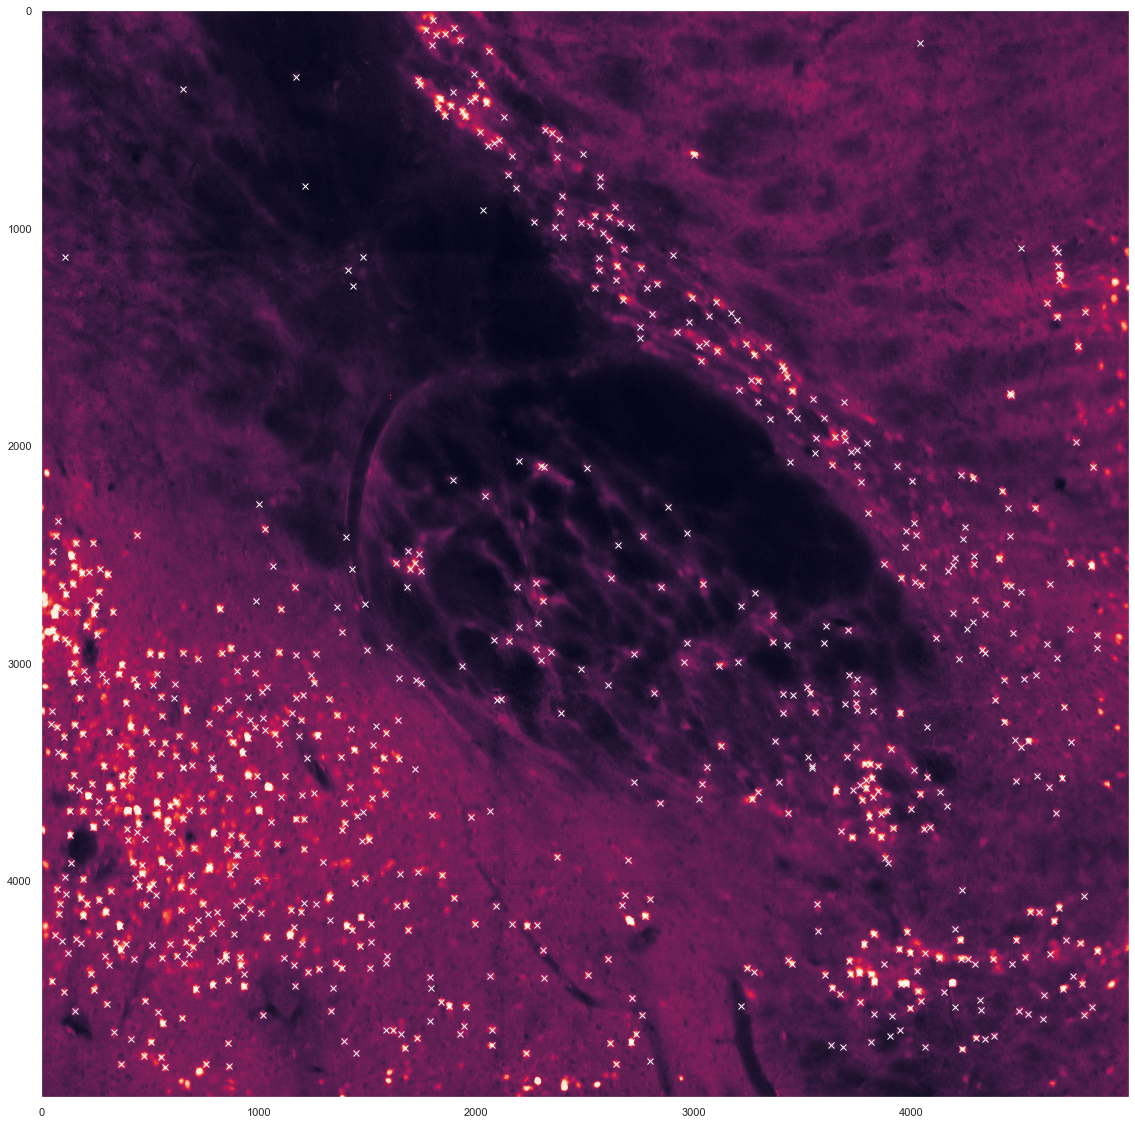

In [7]:

plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(pred_dataset.IM[:,:,1])/(2**16),vmin=0,vmax=0.05)
x = com_r.copy() 
plt.plot(x[:,0],x[:,1],'x',color='#ffffff')
plt.grid(False)
plt.show()

#### Remove potential duplicates from entire tile
 - These would mostly occur along shared edges of subtiles. 

In [ ]:
# #TODO
# from sklearn.metrics import pairwise_distances
# d = pairwise_distances(X=com_gt, Y=com, metric='euclidean')
# ind_tp_in_gt = np.any(d<cell_radius,axis=1)
# ind_tp_in_pred = np.any(d<cell_radius,axis=0)